## VAEs- Deep Unsupervised Learning Project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from IPython.display import clear_output
import time

### Import libraries
### Choose device
### Define transformations
### Load datasets
### Inspect a batch (for understanding)
### Visualize sample images (for understanding)

In [2]:
# Choose device

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)


# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets

train_set = datasets.FashionMNIST('Data_FashionMNIST/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.FashionMNIST('DATA_FashionMNIST/', download=True, train=False, transform=transform)
testLoader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

cuda


In [3]:
def visualize_reconstructed_batch(model, data, reconstructed_data):
    # Get a grid of images from the batch
    images = data.view(-1, 28, 28)
    reconstructed_images = reconstructed_data.view(-1, 28, 28)
    
    # Ajustar el tamaño de la cuadrícula
    fig, axs = plt.subplots(2, len(images), figsize=(10, 5))
    
    # Verificar la lógica de indexación
    for i in range(len(reconstructed_images)):
        axs[0, i].imshow(images[i].detach().numpy(), cmap="gray")  # Salia un error relacionado a arrays, añadió detach() y numpy()
        axs[0, i].set_title("Original")
        axs[0, i].axis('off')

        axs[1, i].imshow(reconstructed_images[i].detach().numpy(), cmap="gray")  # Se añadió detach() y numpy()
        axs[1, i].set_title("Reconstructed")
        axs[1, i].axis('off')

    fig.suptitle("Sample Reconstructed Images")
    plt.tight_layout()
    plt.show()



In [46]:
class ConvAutoEncoder(nn.Module):
    def __init__(self, num_hidden=8):
        super().__init__()
        
        # Set the number of hidden units
        self.num_hidden = num_hidden
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, num_hidden)
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(num_hidden, 32*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        # Pass the input through the encoder
        encoded = self.encoder(x)
        # Pass the encoded representation through the decoder
        decoded = self.decoder(encoded)
        # Return both the encoded representation and the reconstructed output
        return encoded, decoded



In [51]:
class ConvVAE(ConvAutoEncoder):
    def __init__(self, num_hidden=8):
        super().__init__(num_hidden=num_hidden)
        # Add mu and log_var layers for reparameterization
        self.encoded_size = num_hidden
        self.mu = nn.Linear(self.encoded_size, self.num_hidden)
        self.log_var = nn.Linear(self.encoded_size, self.num_hidden)

    def reparameterize(self, mu, log_var):
        # Compute the standard deviation from the log variance
        std = torch.exp(0.5 * log_var)
        # Generate random noise using the same shape as std
        eps = torch.randn_like(std)
        # Return the reparameterized sample
        return mu + eps * std
    
    def sample(self, num_samples):
        with torch.no_grad():
            # Generate random noise
            z = torch.randn(num_samples, self.num_hidden).to(device)
            
            # Pass the noise through the decoder to generate samples
            print(z.shape)
            samples = self.decoder(z)  # Reshape z to match decoder input size
        # Return the generated samples
        return samples
    
    def forward(self, x):
        # Pass the input through the encoder
        encoded = self.encoder(x)
        #print(encoded.shape)
        # Flatten the encoded representation
        encoded_flat = torch.flatten(encoded, start_dim=1)
        #print(encoded_flat.shape)
        # Compute the mean and log variance vectors
        mu = self.mu(encoded_flat)
        log_var = self.log_var(encoded_flat)
        # Reparameterize the latent variable
        z = self.reparameterize(mu, log_var)
        #print(z.shape)
        # Pass the latent variable through the decoder
        decoded = self.decoder(z)  # Reshape z to match decoder input size
        #print(decoded.shape)
        # Return the encoded output, decoded output, mean, and log variance
        return encoded, decoded, mu, log_var

    



In [52]:
# Define a loss function that combines MSE and Kullback-Leibler divergence
def vae_loss_function(recon_x, x, mu, logvar, lamb=3):
    # Compute the MSE loss between the reconstructed output and the input data
    #y= x.view(-1, 784)
    #print(recon_x.shape,y.shape)
    MSE = F.mse_loss(recon_x, x, reduction="sum")

    # Compute the Kullback-Leibler divergence between the learned latent variable distribution and a standard Gaussian distribution
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Combine the two losses by adding them together and return the result
    return MSE + lamb * KLD

In [53]:
def train_vae(model, batch_size=64, learning_rate=1e-3, num_epochs=15):
    # Convert the training data to PyTorch tensors
    
   
    #X_train = torch.from_numpy(X_train_np)

    # Create optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Set the device to GPU if available, otherwise use CPU
    model.to(device)

    # Create a DataLoader to handle batching of the training data
    #train_loader = torch.utils.data.DataLoader(
    #    X_train, batch_size=batch_size, shuffle=True
    #)

    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_idx, (data,_) in enumerate(trainLoader):
            # Get a batch of training data and move it to the device           
            data = data.to(device)
            
            # Forward pass
            encoded, decoded, mu, log_var = model(data)

            # Compute the loss and perform backpropagation
            loss = vae_loss_function(decoded, data, mu, log_var, lamb=3)/len(data)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update the running loss
            total_loss += loss.item() * data.size(0)

        # Print the epoch loss
        epoch_loss = total_loss / len(trainLoader.dataset)
        print(
            "Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss)
        )

In [54]:
model = ConvVAE(num_hidden=8)
train_vae(model)

Epoch 1/15: loss=129.3233
Epoch 2/15: loss=101.6288
Epoch 3/15: loss=96.6663
Epoch 4/15: loss=94.1954
Epoch 5/15: loss=92.4105
Epoch 6/15: loss=91.4507
Epoch 7/15: loss=90.7309
Epoch 8/15: loss=90.1348
Epoch 9/15: loss=89.6993
Epoch 10/15: loss=89.2854
Epoch 11/15: loss=88.9484
Epoch 12/15: loss=88.6777
Epoch 13/15: loss=88.3662
Epoch 14/15: loss=88.2539
Epoch 15/15: loss=87.9886


torch.Size([1, 8])


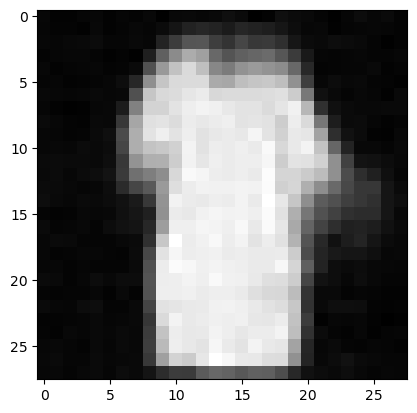

In [23]:
model.eval()

decoded = model.sample(1).squeeze().cpu().numpy()

plt.imshow(decoded, cmap="gray")
plt.show()

torch.Size([1, 8])


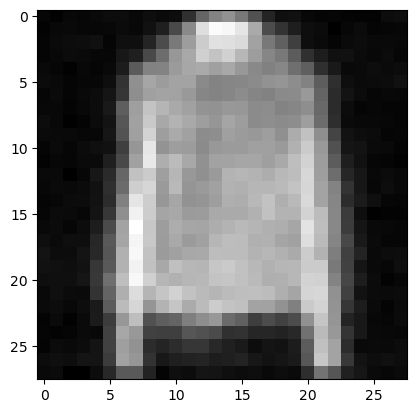

torch.Size([1, 8])


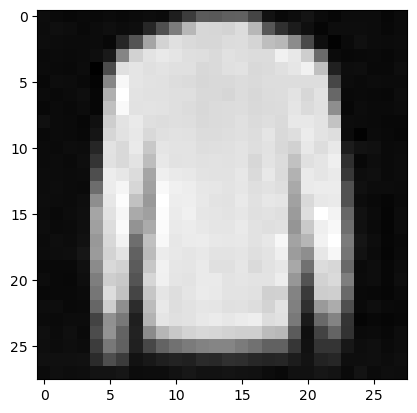

torch.Size([1, 8])


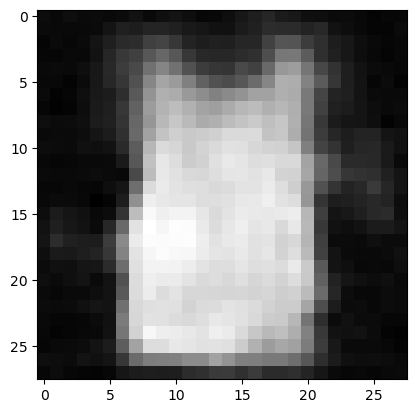

torch.Size([1, 8])


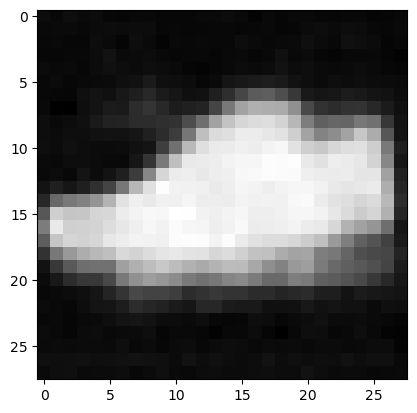

torch.Size([1, 8])


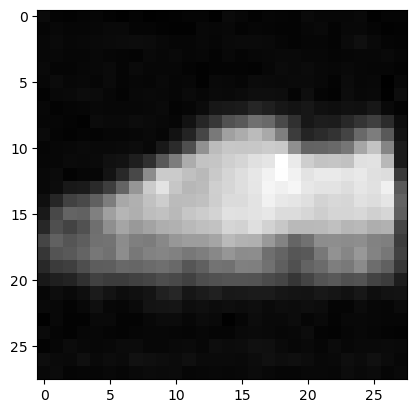

In [25]:
for i in range(5):
    model.eval()

    decoded = model.sample(1).squeeze().cpu().numpy()


    plt.imshow(decoded, cmap="gray")
    plt.show()